## Imports
---

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime
from src.heikin_ashi import heikin_ashi
from src.indicators import supertrend, VWAP2, smc, wavetrend3d
import pandas_ta as ta

## Getting the Data
---

In [3]:
forex_data = pd.read_csv("./data_directory/cumulative_data.csv")
forex_data['timestamp'] = pd.to_datetime(forex_data['timestamp'], unit='ms')
forex_data['timestamp'] = pd.to_datetime(forex_data['timestamp'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S')))
forex_data.set_index('timestamp', inplace=True)
forex_data.drop_duplicates(inplace=True)


## Polygon API
---

In [4]:
hello = wavetrend3d(forex_data["Close"], 6, "1H")

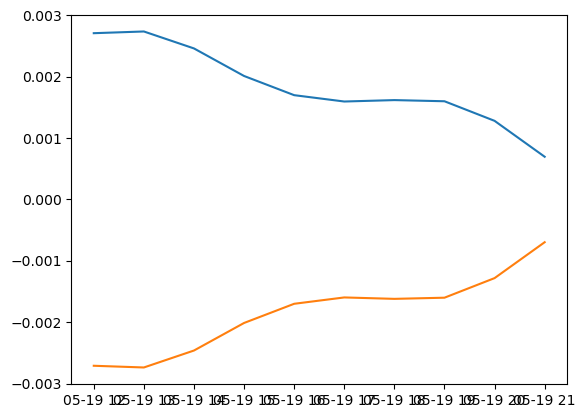

In [5]:

plt.plot(hello[0][16745:16755])
plt.plot(hello[1][16745:16755])


# Kleines Tutorial für Backtesting.py

Es besteht aus einen init part wo alle variablen definiert und initialisiert werden und einen next part wo der algorithmus nach und nach jede candle durchgeht. Dabei kann man die zurzeitige Candle mit __self.data.Close[-1]__ abrufen. Dir davor mit -2 usw. Ihr könnt außerdem dabei zwischen Close, Open, High, Low entscheiden. 

Um die zurzeitige Balance zu bekommen ruft ihr $self.equity$ auf. 

Um Indicatoren hinzuzufügen habt ihr folgende Syntax:

__self.IndicatorName = self.I(Indicator, Parameter1, Parameter2, ...)__

Dabei könnt ihr die jetzigen Werte abrufen wie mit den Daten [-n],  $n \in \mathbb{N}$ .

Um Trades einzugehen bentzt man entweder:

__self.buy(size=deineGroesse)__ 

__self.sell(size=deineGroesse)__

Ihr müsst dabei geachten das man entweder die Share anzahl als Integer übergebt oder die eine Kommazahl von $[0,1)$ die darstellt wie viel Prozent deines Portfolios du reinsetzt hast.

um eine Position zu schließen benutzt ihr: 

__self.position.close()__

Das sind so die wichtigsten Befehle. Leider lässt die libary nicht mehrere Positionen gleichzeitig. Falls ihr das umbedingt braucht kann ich nach einer anderen Libary ausschau halten. 

Falls ihr irgendwelche anderen Befehle braucht wie z.B. eine LimitOrder oder sowas dann findet ihr die unter den Documentations: 

- https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#gsc.tab=0


## The Strategy
---

In [ ]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import talib as tab

#Hier die Werte die ihr abändern könnt
shorts = True
longs = True
candlecountEntry = 7 # Nach wie vielen noch geschaut wird ob buy/sell signal kommt
stoplossCandles = 10 # Beim Entry -> Wie viele candles er nach hinten schauen soll für sl

class PIES(Strategy):
    def init(self):
        # Store orderblock values
        self.orderblocksU = []
        self.orderblocksB = []
        # If orderblock got hit and price is above/below upperbands/lowerbands
        self.tagged = False
        self.taggedprice = 0
        self.taggeddev = 0
        # Counter of how many candles it was ago when orderblock got tagged
        self.taggedcounter = 0
        # Overall candle count
        self.candlecount = 17
        self.trade_opened = False
        self.stoploss = 0
        self.sholong = 0  #0 stands for long trade and 1 for short trade
        # Values that act as a buffer for the orderblocks after they got hit
        self.orderblocklow = 0
        self.orderblockhigh = 0

        # Supertrend Indicator
        self.supertrendu = self.I(supertrend, self.data.df, lookback=10, multiplier=2.5, band=0)
        self.supertrendl = self.I(supertrend, self.data.df, lookback=10, multiplier=2.5, band=1)
        # VWAP Indicator
        self.vwap = self.I(VWAP2, self.data.df, 0)
        self.vwapu1 = self.I(VWAP2, self.data.df, 1)
        self.vwapl1 = self.I(VWAP2, self.data.df, 2)
        self.vwapu2 = self.I(VWAP2, self.data.df, 3)
        self.vwapl2 = self.I(VWAP2, self.data.df, 4)
        self.vwapu3 = self.I(VWAP2, self.data.df, 5)
        self.vwapl3 = self.I(VWAP2, self.data.df, 6)
        # Orderblock Indicator
        self.upperOB = self.I(smc, self.data.df, length=10, band=1)
        self.lowerOB = self.I(smc, self.data.df, length=10, band=0)
        # ATR Indicator
        self.atr = self.I(tab.ATR, self.data.High, self.data.Low, self.data.Close, 14)

    def next(self):
        # Add orderblocks

        if(self.upperOB[-1] > 0):
            self.orderblocksU.append([self.data.High[-1], self.data.Low[-1], self.candlecount])
        if(self.lowerOB[-1] > 0):
            self.orderblocksB.append([self.data.High[-1], self.data.Low[-1], self.candlecount])
        # If no trade is open
        if not self.trade_opened and self.data.index[-1].hour > 6 and self.data.index[-1].hour < 12:
            # If it didnt hit orderblock + upper/lower band yet
            if self.tagged==False:
                # For loops to iterate through the orderblocks and check if they got hit
                if shorts:
                    for high, low, candle in self.orderblocksU:
                        if self.data.High[-1] > low and self.data.High[-1] < high and self.candlecount - candle < 1000 and ((self.data.High[-1] > self.vwapu2[-1] - (self.atr[-1]/2) and self.data.High[-1] < self.vwapu2[-1] + (self.atr[-1]/2)) or (self.data.High[-1] > self.vwapu3[-1] - (self.atr[-1]/2) and self.data.High[-1] < self.vwapu3[-1] + (self.atr[-1]/2))):
                            self.tagged = True
                            if(self.data.High[-1] < self.vwapu2[-1] + (self.atr[-1]/2)):
                                self.taggeddev = 2
                            else:
                                self.taggeddev = 3
                            self.taggedprice = self.data.High[-1]
                            self.orderblocklow = low
                            self.sholong = 1
                            self.orderblocksU.remove([high, low, candle])
                            break
                if longs:
                    for high, low, candle in self.orderblocksB:
                        if self.data.Low[-1] < high and self.data.Low[-1] > low and self.candlecount - candle < 1000 and ((self.data.Low[-1] < self.vwapl2[-1] + (self.atr[-1]/2) and self.data.Low[-1] > self.vwapl2[-1] - (self.atr[-1]/2)) or (self.data.Low[-1] < self.vwapl3[-1] + (self.atr[-1]/2) and self.data.Low[-1] > self.vwapl3[-1] - (self.atr[-1]/2))):
                            self.tagged = True
                            if(self.data.Low[-1] > self.vwapl2[-1] - (self.atr[-1]/2)):
                                self.taggeddev = 2
                            else:
                                self.taggeddev = 3
                            self.orderblockhigh = high
                            self.sholong = 0
                            self.orderblocksB.remove([high, low, candle])
                            break

            # If it hit and we have to go short
            elif (self.tagged == True and self.sholong == 1):
                # Heikin Ashi Candles)
                ha_close = 1/4*(self.data.Open[-1] + self.data.Close[-1] + self.data.High[-1] + self.data.Low[-1])
                ha_open = 1/2*(self.data.Open[-2] + self.data.Close[-2])
                ha_high = max(self.data.High[-1], ha_open, ha_close)
                ha_low = min(self.data.Low[-1], ha_open, ha_close)
                if((self.data.High[-1] > self.vwapu2[-1] + (self.atr[-1]/2) and self.taggeddev == 2) or (self.data.High[-1] > self.vwapu3[-1] + (self.atr[-1]/2) and self.taggeddev == 3)):
                    self.tagged = False
                else:
                    if self.taggedcounter < candlecountEntry:
                        if self.data.High[-1] < self.orderblocklow and ha_open > (ha_high - ((ha_high - ha_low)*0.12) and self.data.Close[-1]>self.vwapu1[-1]):
                            self.trade_opened = True
                            self.stoploss = 0
                            for i in range(1, stoplossCandles):
                                if self.data.High[-i] > self.stoploss:
                                    self.stoploss = self.data.High[-i]
                            def berechnen(kapital, stoploss, entry):
                                    diff = stoploss - entry
                                    size = abs((kapital/10000) / diff)
                                    return int(round(size,0))
                            sizeO = berechnen(self.equity, self.stoploss, self.data.Close[-1])
                            try:
                                self.sell(size=sizeO)
                            except:
                                print("Something went wrong")
                        self.taggedcounter += 1
                    else: 
                        self.tagged = False
                        self.taggedcounter = 0
            # If it hit and we have to go long
            elif (self.tagged == True and self.sholong == 0):
                # Heikin Ashi Candles
                ha_close = 1/4*(self.data.Open[-1] + self.data.Close[-1] + self.data.High[-1] + self.data.Low[-1])
                ha_open = 1/2*(self.data.Open[-2] + self.data.Close[-2])
                ha_high = max(self.data.High[-1], ha_open, ha_close)
                ha_low = min(self.data.Low[-1], ha_open, ha_close)
                if((self.data.Low[-1] < self.vwapl2[-1] - (self.atr[-1]/2) and self.taggeddev == 2) or (self.data.Low[-1] < self.vwapl3[-1] - (self.atr[-1]/2) and self.taggeddev == 3)):
                    self.tagged = False
                if self.taggedcounter < candlecountEntry:
                    if self.data.Low[-1] > self.orderblockhigh and ha_open < (ha_low + (ha_high - ha_low) * 0.12) and self.data.Close[-1]<self.vwapl1[-1]:
                        self.stoploss = 100 # Set stoploss to high value
                        for i in range(1, stoplossCandles):
                            if self.data.Low[-i] < self.stoploss:
                                self.stoploss = self.data.Low[-i]
                        def berechnen(kapital, stoploss, entry):
                            diff = stoploss - entry
                            size = abs((kapital/10000) / diff)
                            return int(round(size,0))
                        sizeO = berechnen(self.equity, self.stoploss, self.data.Close[-1])
                        try:
                            self.buy(size=sizeO)
                        except:
                            print("Something went wrong")
                        self.trade_opened = True
                    self.taggedcounter += 1
                else: 
                    self.tagged = False
                    self.taggedcounter = 0
        

        elif self.trade_opened: # Stop loss path
            if self.sholong == 0:
                if(self.supertrendl[-2] > 0 and self.supertrendu[-1] > 0) or self.data.Close[-1] < self.stoploss:
                    self.position.close()
                    self.trade_opened = False
                    self.tagged = False
            elif self.sholong == 1:
                if(self.supertrendu[-2] > 0 and self.supertrendl[-1] > 0) or self.data.Close[-1] > self.stoploss:
                    self.position.close()
                    self.trade_opened = False
                    self.tagged = False
        self.candlecount = self.candlecount + 1
        
bt2 = Backtest(forex_data[:100000], PIES, cash=1000000, commission=0.00, exclusive_orders=True)
# Run the backtest and append the results to the list
output2 = bt2.run()
# Print the results
print(output2)

bt2.plot(filename="./ChartPlots/PIES_20.05.23_0.html", plot_volume=False)

In [21]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

# Parameter für Philip

atr_window = 6
einsatz = 0.5 # Hier stehen Kommazahlen für den Prozentuallen Anteil deiner Equity die du setzen willst
# Oder du kannst auch ganze Zahlen nuzen für die Anzahl der Shares die du kaufen willst. Falls du alles reinsetzen
# Willst benutz 0.9999
satr = 3 # * atr in stoploss
tatr = 9 # * atr in take profit


class PIIL(Strategy):
    def init(self):
        self.trade_opened = False
        self.take_profit = 0
        self.sl = 0
        self.atr = self.I(tab.ATR, self.data.High, self.data.Low, self.data.Close, atr_window)

    def next(self):
        if not self.trade_opened and self.data.index[-1].hour == 5 and self.data.index[-1].minute == 0:
            self.buy(size=einsatz)
            self.sl = self.data.Close[-1] - satr * self.atr[-1]
            self.take_profit = self.data.Close[-1] + tatr * self.atr[-1]
            self.trade_opened = True

        elif self.trade_opened:
            if self.data.Close[-1] > self.take_profit or self.data.Close[-1] < self.sl:
                self.position.close()
                self.trade_opened = False
                self.take_profit = 0
                self.sl = 0


class PIIS(Strategy):
    def init(self):
        self.candlecount = 0
        self.trade_opened = False
        self.take_profit = 0
        self.sl = 0
        self.atr = self.I(tab.ATR, self.data.High, self.data.Low, self.data.Close, atr_window)

    def next(self):
        if not self.trade_opened and self.data.index[-1].hour == 5 and self.data.index[-1].minute == 0:
            self.sl = self.data.Close[-1] + satr*self.atr[-1]
            self.take_profit = self.data.Close[-1] - tatr*self.atr[-1]
            self.sell(size=einsatz)
            self.trade_opened = True

        elif self.trade_opened:
            if self.data.Close[-1] < self.take_profit or self.data.Close[-1] > self.sl:
                self.position.close()
                self.trade_opened = False
                self.take_profit = 0
                self.sl = 0



bt = Backtest(forex_data,PIIL, cash=1000000, commission=0.00, exclusive_orders=True)
bt2 = Backtest(forex_data,PIIS, cash=1000000, commission=0.00, exclusive_orders=True)

output = bt.run()
print(output)

output2 = bt2.run()
print(output2)


Start                     2021-06-20 19:00:00
End                       2023-05-19 21:03:00
Duration                    698 days 02:03:00
Exposure Time [%]                   17.742746
Equity Final [$]                 993237.06753
Equity Peak [$]                 1007818.72049
Return [%]                          -0.676293
Buy & Hold Return [%]               -8.775154
Return (Ann.) [%]                   -0.263955
Volatility (Ann.) [%]                1.456316
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -1.850184
Avg. Drawdown [%]                   -0.074406
Max. Drawdown Duration      485 days 02:06:00
Avg. Drawdown Duration        8 days 15:46:00
# Trades                                  484
Win Rate [%]                        26.033058
Best Trade [%]                       0.890181
Worst Trade [%]                     -0.677589
Avg. Trade [%]                    

In [31]:
bt2.plot()

/Users/dennisschielke/miniconda3/envs/pie/lib/python3.8/site-packages/backtesting/_plotting.py:122: UserWarning: Data contains too many candlesticks to plot; downsampling to '2H'. See `Backtest.plot(resample=...)`
  warnings.warn(f"Data contains too many candlesticks to plot; downsampling to {freq!r}. "
/Users/dennisschielke/miniconda3/envs/pie/lib/python3.8/site-packages/backtesting/_plotting.py:148: FutureWarning: Passing method to Int64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  new_bar_idx = new_index.get_loc(mean_time, method='nearest')
/Users/dennisschielke/miniconda3/envs/pie/lib/python3.8/site-packages/backtesting/_plotting.py:148: FutureWarning: Passing method to Int64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  new_bar_idx = new_index.get_loc(mean_time, method='nearest')
/Users/dennisschielke/miniconda3/envs/pie/lib/python3.8/site-pa

GridPlot(id='p2679', ...)